# Generative model to create paths

In [59]:
# Generative model to create paths
import random; random.seed(23)
from linecache import getline
from pathlib import Path

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b

def count_lines(file_path):
    with open(file_path, "r",encoding="utf-8",errors='ignore') as f:
        return sum(bl.count("\n") for bl in blocks(f))


class PathDataset(Dataset):
    def __init__(self, file_path: Path):
        self.path_str = str(file_path)
        self.num_lines = count_lines(file_path)
        self.lines = [i for i in range(self.num_lines)]

    def __len__(self) -> int:
        return self.num_lines

    def __getitem__(self, key) -> list[str]:
        if isinstance(key, slice):  # List slicing
            indices = range(*key.indices(self.num_lines))
            return [self[i] for i in indices]
        else:  # Single index
            idx = self.lines[key]
            line = getline(self.path_str, idx+1)  # getline indexes at 1
            if len(line) > 0:
                start_pos = line.find(':') + 1
                line = line[start_pos:].strip()
                line = line.split(' ')
            return line
            
    def shuffle(self):
        random.shuffle(self.lines)
    
    def items(self):
        for i in range(self.num_lines):
            yield self[i]

dataset = PathDataset(Path('../data/paths.txt'))
print(len(dataset))
print(dataset[0])

649931
['FILE', 'READ_Access_File', 'PROCESS_LET_fluxbox', 'PROC_CREATE_Start_Processlet', 'PROCESS_LET_/usr/bin/firefox']


In [60]:
tokens = set()
distinct_paths = set()

def tokenize(path):
    assert len(path) % 2 == 1
    path.append('.')
    return [f'{path[idx]}|{path[idx+1]}' for idx in range(0, len(path), 2)]

for path in dataset.items():
    path = tokenize(path)
    tokens.update(path)
    distinct_paths.add(' '.join(path))
tokens = list(tokens)
tokens[:0] = ['.']
itos = tokens
stoi = {
    token: i for i, token in enumerate(itos)
}

print(f'Found {len(tokens)} tokens in {len(dataset)} entries')
print(f'Distinct paths: {len(distinct_paths)}')

Found 35 tokens in 649931 entries
Distinct paths: 468


In [61]:
import torch

batch_size = 64
block_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 0.1

In [62]:
def build_dataset(path_dataset):
    X, Y = [], []

    for path in path_dataset:
        path = tokenize(path)
        context = [0] * block_size
        for i_x in path + ['.']:
            i_x = stoi[i_x]
            X.append(context)
            Y.append(i_x)
            context = context[1:] + [i_x] # Pop, add to back

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(dataset))
n2 = int(0.9 * len(dataset))
X_train, Y_train = build_dataset(dataset[:n1])
X_dev,   Y_dev   = build_dataset(dataset[n1:n2])
X_test,  Y_test  = build_dataset(dataset[n2:])

torch.Size([8061609, 8]) torch.Size([8061609])
torch.Size([2510948, 8]) torch.Size([2510948])
torch.Size([2504728, 8]) torch.Size([2504728])


In [70]:
import torch.nn as nn

vocab_size = len(tokens)
n_embedding = 10 # Embedding dimension
n_hidden = 100

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embedding),
    nn.Flatten(),
    nn.Linear(n_embedding * block_size, n_hidden), nn.ReLU(),
    nn.Linear(n_hidden, vocab_size), 
    nn.Sigmoid()
)
lossi = []


In [64]:
layers = [m for m in model.children()]
layers

[Embedding(35, 10),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=80, out_features=100, bias=True),
 ReLU(),
 Linear(in_features=100, out_features=35, bias=True),
 Sigmoid()]

In [34]:
batch_indices = torch.randint(0, X_train.shape[0], (batch_size,))
X_b = X_train[batch_indices]
Y_b = Y_train[batch_indices]
out = model(X_b)
print(out, Y_b)
F.cross_entropy(model(X_b), Y_b)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], grad_fn=<SigmoidBackward0>) tensor([ 5,  1,  7,  1,  1,  5, 13, 13,  1, 13,  5, 13,  5, 13, 12, 15, 13, 13,
         1, 13, 10,  5, 13, 13,  1,  5,  5, 13, 11,  1, 13,  5,  5,  5, 13,  5,
         5,  5,  1, 13, 13, 13, 13,  1, 13, 13, 13, 13, 13,  5, 10, 13,  4,  5,
         5, 13,  1,  5,  7,  1, 11,  7,  1, 13])


tensor(2.3890, grad_fn=<NllLossBackward0>)

In [71]:
from tqdm import tqdm
max_steps = 200000
for i in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    X_batch, Y_batch = X_train[ix], Y_train[ix]

    # Forward pass
    logits = model(X_batch) # output layer
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in model.parameters():
        p.requires_grad = True
    loss.backward()
    
    # update
    for p in model.parameters():
        p.data += -learning_rate * p.grad

    # Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    


      0/ 200000: 3.5169
  10000/ 200000: 3.5637
  20000/ 200000: 3.4204
  30000/ 200000: 3.4794
  40000/ 200000: 3.3892
  50000/ 200000: 3.4207
  60000/ 200000: 3.5062
  70000/ 200000: 3.3534
  80000/ 200000: 3.3200
  90000/ 200000: 3.4635
 100000/ 200000: 3.5009
 110000/ 200000: 3.4049
 120000/ 200000: 3.3822
 130000/ 200000: 3.3876
 140000/ 200000: 3.3430
 150000/ 200000: 3.4752
 160000/ 200000: 3.4104
 170000/ 200000: 3.4016
 180000/ 200000: 3.3714
 190000/ 200000: 3.4453


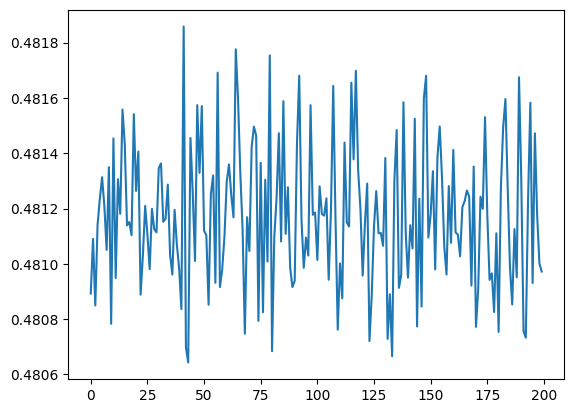

In [69]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [67]:
# Sample from the model
with torch.no_grad():
    for _ in range(20):
        # Forward pass
        out = []
        context = [0] * block_size
        while True and len(out) < 100:
            logits = model(torch.tensor([context]))
            probabilities = F.softmax(logits, dim=1)
            # Sample from distribution
            ix = torch.multinomial(probabilities, num_samples=1).item()

            # Shift context window
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break
        print(' '.join(itos[i] for i in out))

.
PROCESS_LET_/usr/bin/pulseaudio|WRITE_Access_File PROCESS_LET|PROC_CREATE_Start_Processlet PROCESS_LET_/home/admin/Downloads/firefox/firefox|PROC_CREATE_Start_Processlet PROCESS_LET_fluxbox|WRITE_Access_File PROCESS_LET|WRITE_Access_File FILE_/home/admin/.pulse/263ceeca39f67879e8eda45300000001-default-source|. PROCESS_LET_/home/admin/Downloads/firefox/firefox|PROC_CREATE_Start_Processlet FILE_/dev/glx_alsa_675|READ_Access_File FILE_/home/admin/.pulse/263ceeca39f67879e8eda45300000001-default-source|. FILE_/home/admin/.mozilla/firefox/pe11scpa.default/sessionstore.js.tmp|. FILE_/home/admin/.local/share/applications/mimeapps.list.1QOUGZ|READ_Access_File PROCESS_LET_/home/admin/Downloads/firefox/firefox|WRITE_Access_File .
FILE_/home/admin/.pulse/263ceeca39f67879e8eda45300000001-default-source|READ_Access_File FILE_/home/admin/.mozilla/firefox/pe11scpa.default/cookies.sqlite|READ_Access_File FILE_/home/admin/.pulse/263ceeca39f67879e8eda45300000001-default-source|READ_Access_File FILE_/ho